In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [ ]:
# HYPERPARAMS
num_epochs = 20
batch_size = 128
lr = 0.01

# CONSTANTS
NUM_CLASSES = 10

# cuda availability
cuda_available = torch.cuda.is_available()
device = "cuda" if cuda_available else "cpu"

In [ ]:
train = torchvision.datasets.MNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                                                     transforms.ToTensor()
                       ]))
test = torchvision.datasets.MNIST('./data', 
                      train=False,
                      download=True,
                      transform=transforms.Compose([
                                                     transforms.ToTensor()
                       ]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, title: str="Class label"):
    """
    This function essentially takes in normalized tensors and the
    Un-normalize them and display the image as output.

    Args:
    ----
    image: Image which we want to plot.
    title: Label for that image.
    """
    image = image.numpy().transpose((1, 2, 0)) # (C, H, W) --> (H, W, C)
    # Convert mean and std to numpy array
    mean = np.asarray(DATA_MEAN)
    std = np.asarray(DATA_STD)
    # unnormalize the image
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    print(title)
    fig = plt.figure() # Create a new figure
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111)
    ax.axis("off") # Sqitch off the axis
    ax.imshow(image)

['6', '1', '4', '0', '7', '1', '8', '9', '0', '1', '2', '4', '2', '5', '9', '3', '9', '5', '1', '4', '1', '1', '3', '3', '2', '4', '3', '7', '8', '8', '1', '1', '4', '5', '4', '5', '0', '1', '0', '0', '7', '3', '7', '5', '0', '4', '1', '5', '3', '7', '9', '4', '6', '2', '6', '8', '5', '1', '5', '0', '0', '0', '3', '9', '9', '2', '4', '9', '2', '0', '3', '6', '5', '1', '9', '8', '9', '3', '1', '6', '6', '1', '0', '3', '8', '0', '9', '8', '5', '3', '3', '0', '8', '4', '1', '9', '7', '0', '2', '4', '8', '4', '7', '8', '5', '6', '1', '8', '5', '8', '3', '5', '0', '3', '0', '4', '7', '4', '3', '8', '4', '7', '1', '5', '0', '5', '5', '7']


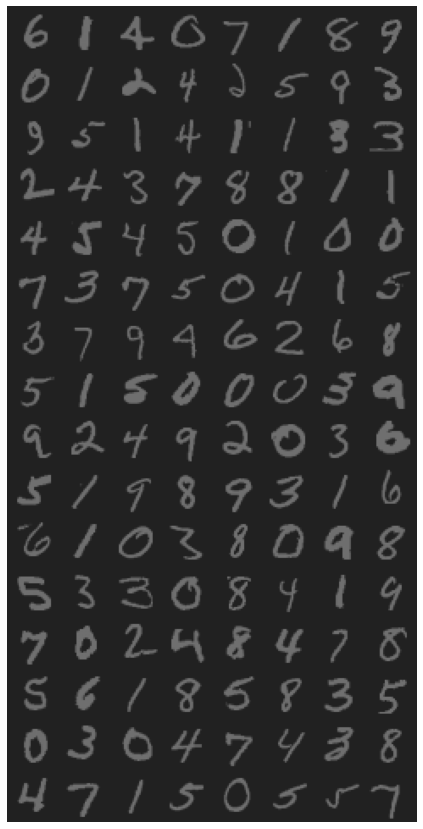

In [ ]:
# Iteratre over and get 1 batch of training data
data, targets = next(iter(train_loader))

# make_grid takes all tensors(batch) and joins them into a single big tensor image (almost)
batch_grid = torchvision.utils.make_grid(data) 

display_image(batch_grid, title=[str(cls.item()) for cls in targets])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        self.classifier = nn.Linear(16, 10)

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock8(x)


        x = x.view(-1, 16)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 4, 24, 24]              64
         MaxPool2d-6            [-1, 4, 12, 12]               0
            Conv2d-7            [-1, 8, 10, 10]             288
              ReLU-8            [-1, 8, 10, 10]               0
            Conv2d-9             [-1, 16, 8, 8]           1,152
             ReLU-10             [-1, 16, 8, 8]               0
           Conv2d-11             [-1, 48, 6, 6]           6,912
             ReLU-12             [-1, 48, 6, 6]               0
        AvgPool2d-13             [-1, 48, 1, 1]               0
           Conv2d-14             [

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2920348346233368 Batch_id=468 Accuracy=77.58: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2139, Accuracy: 9317/10000 (93.17%)

EPOCH: 1


Loss=0.14093023538589478 Batch_id=468 Accuracy=92.84: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2135, Accuracy: 9391/10000 (93.91%)

EPOCH: 2


Loss=0.40591809153556824 Batch_id=468 Accuracy=94.03: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3785, Accuracy: 8907/10000 (89.07%)

EPOCH: 3


Loss=0.10427825897932053 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:13<00:00, 35.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9759/10000 (97.59%)

EPOCH: 4


Loss=0.11811722069978714 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9751/10000 (97.51%)

EPOCH: 5


Loss=0.10031693428754807 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 9777/10000 (97.77%)

EPOCH: 6


Loss=0.052804138511419296 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9797/10000 (97.97%)

EPOCH: 7


Loss=0.06017729267477989 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9799/10000 (97.99%)

EPOCH: 8


Loss=0.010122905485332012 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:13<00:00, 34.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9803/10000 (98.03%)

EPOCH: 9


Loss=0.017250806093215942 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9796/10000 (97.96%)

EPOCH: 10


Loss=0.05821603536605835 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9795/10000 (97.95%)

EPOCH: 11


Loss=0.12737025320529938 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9797/10000 (97.97%)

EPOCH: 12


Loss=0.07719641178846359 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9797/10000 (97.97%)

EPOCH: 13


Loss=0.07856769859790802 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9796/10000 (97.96%)

EPOCH: 14


Loss=0.04498332366347313 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]



Test set: Average loss: 0.0595, Accuracy: 9796/10000 (97.96%)



Text(0.5, 1.0, 'Test Accuracy')

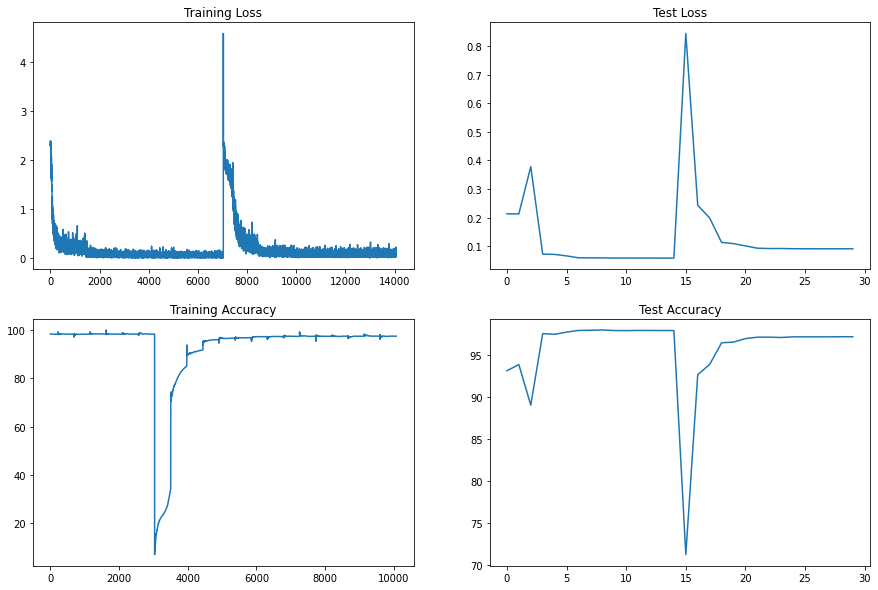

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")